<a href="https://colab.research.google.com/github/Manikanta123A/Price-Prediction-/blob/main/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import pandas as pd

file_id = "1U4XEQKSXEFmD1kN9V1_pbKCVCMSGktJD"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url)

df_first_two = df.iloc[:5000,:2]


print(df_first_two.head())


   sample_id                                    catalog_content
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...
1     198967  Item Name: Salerno Cookies, The Original Butte...
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...


In [2]:
missing_values = df_first_two.isnull().sum()
print("Missing values in Data:\n", missing_values)


# 1.3 Analyze data types and preview catalog_content
print("Data types:\n", df_first_two.dtypes)
print(df_first_two['catalog_content'].head())

# 1.4 Statistical info on catalog_content length
df_first_two['text_length'] = df_first_two['catalog_content'].apply(lambda x: len(str(x)))

print("DataSet catalog_content length stats:", df_first_two['text_length'].describe())


Missing values in Data:
 sample_id          0
catalog_content    0
dtype: int64
Data types:
 sample_id           int64
catalog_content    object
dtype: object
0    Item Name: La Victoria Green Taco Sauce Mild, ...
1    Item Name: Salerno Cookies, The Original Butte...
2    Item Name: Bear Creek Hearty Soup Bowl, Creamy...
3    Item Name: Judee’s Blue Cheese Powder 11.25 oz...
4    Item Name: kedem Sherry Cooking Wine, 12.7 Oun...
Name: catalog_content, dtype: object
DataSet catalog_content length stats: count    5000.000000
mean      897.024200
std       860.598395
min        37.000000
25%       238.000000
50%       628.500000
75%      1250.250000
max      6192.000000
Name: text_length, dtype: float64


In [3]:
df_first_two.iloc[0,1]

'Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n'

In [4]:
df.columns

Index(['sample_id', 'catalog_content', 'image_link', 'price'], dtype='object')

In [5]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)


In [7]:

df_cleaned = df_first_two.copy()
df_cleaned[df_cleaned.columns[1]] = df_cleaned.iloc[:, 1].apply(clean_text)
print(df_cleaned.head())

   sample_id                                    catalog_content  text_length
0      33127  item name: la victoria green taco sauce mild, ...           91
1     198967  item name: salerno cookies, original butter co...          511
2     261251  item name: bear creek hearty soup bowl, creamy...          328
3      55858  item name: judee’s blue cheese powder 11.25 oz...         1318
4     292686  item name: kedem sherry cooking wine, 12.7 oun...          155


In [8]:
df_cleaned.iloc[0,1]

'item name: la victoria green taco sauce mild, 12 ounce (pack 6) value: 72.0 unit: fl oz'

In [9]:
def extract_value_unit(text):

    match = re.search(r"([0-9]+\\.?[0-9]*)\\s*([a-zA-Z]+)", text)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Apply and preview on first few rows
preview = df_cleaned['catalog_content'].head(10).apply(extract_value_unit)
print("Extracted value-unit samples:", preview.tolist())

Extracted value-unit samples: [(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]


In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURES = 10000
NGRAM_RANGE = (1,2)

tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    stop_words='english',
)

train_tfidf = tfidf.fit_transform(df_cleaned['catalog_content'])

print("Train TF-IDF shape:", train_tfidf.shape)

feature_names = np.array(tfidf.get_feature_names_out())
mean_weights = train_tfidf.mean(axis=0).A1
top_idx = np.argsort(mean_weights)[::-1][:20]
print("Top 20 TF-IDF features:", feature_names[top_idx])


Train TF-IDF shape: (5000, 10000)
Top 20 TF-IDF features: ['point' 'bullet' 'bullet point' 'ounce' 'oz' 'tea' 'item' 'value' 'unit'
 'pack' 'free' 'coffee' 'unit ounce' 'flavor' 'organic' 'count' 'product'
 '12' 'value unit' 'fl']


In [12]:
top_idx = top_idx[:11]
print(feature_names[top_idx])


['point' 'bullet' 'bullet point' 'ounce' 'oz' 'tea' 'item' 'value' 'unit'
 'pack' 'free']


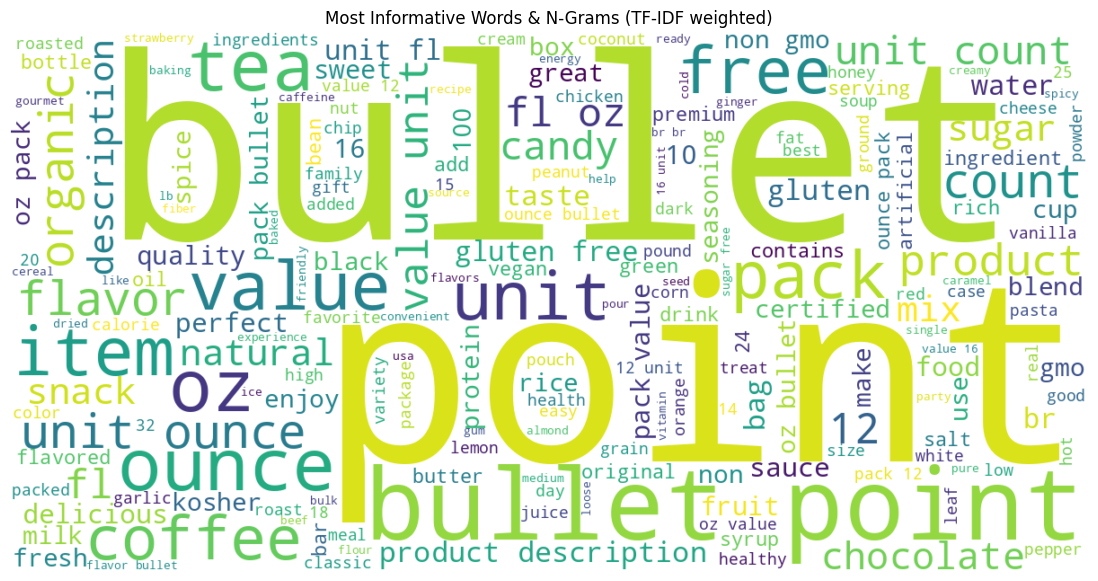

/tmp/ipython-input-2254229476.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names[sorted_idx][:20], y=mean_weights[sorted_idx][:20], palette="Blues_d")


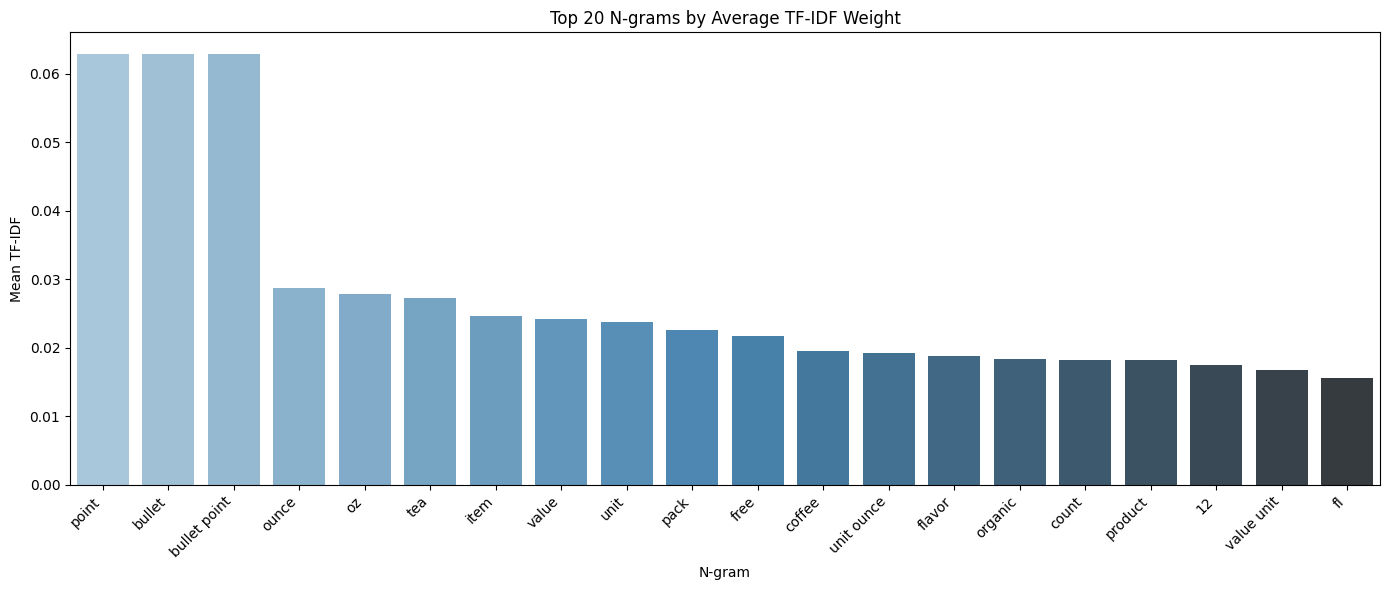

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_n = 1000
feature_names = np.array(tfidf.get_feature_names_out())
mean_weights = train_tfidf.mean(axis=0).A1
sorted_idx = np.argsort(mean_weights)[::-1][:top_n]
freq_dict = {feature_names[i]: mean_weights[i] for i in sorted_idx}

wordcloud = WordCloud(width=1200, height=600, background_color="white", colormap="viridis")
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Informative Words & N-Grams (TF-IDF weighted)")
plt.show()


import seaborn as sns

plt.figure(figsize=(14,6))
sns.barplot(x=feature_names[sorted_idx][:20], y=mean_weights[sorted_idx][:20], palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 N-grams by Average TF-IDF Weight")
plt.xlabel("N-gram")
plt.ylabel("Mean TF-IDF")
plt.tight_layout()
plt.show()

In [14]:
import re
from collections import Counter

RELEVANT_UNITS = ['oz', 'ounce', 'g', 'gram', 'ml', 'l', 'fl', 'bottle', 'pack', 'count', 'bag', 'lb']
def extract_numeric_info(text, units=RELEVANT_UNITS):
    text = text.replace('\n', ' ')
    pattern = r'([0-9]+(?:\.[0-9]+)?)\s*(' + '|'.join(units) + r')s?\b'
    matches = re.findall(pattern, text, flags=re.IGNORECASE)

    features = Counter()
    for val, unit in matches:
        features['num_' + unit.lower()] += float(val)
        features['count_' + unit.lower()] += 1
    features['num_values_found'] = len(matches)
    return features

train_unit_feats = df_cleaned['catalog_content'].apply(extract_numeric_info)


train_unit_feats_df = pd.DataFrame(list(train_unit_feats)).fillna(0)

print("Train unit feature sample (first 2 rows):\n", train_unit_feats_df.head(2))





Train unit feature sample (first 2 rows):
    num_ounce  count_ounce  num_values_found  num_gram  count_gram  num_oz  \
0       12.0          1.0                 1       0.0         0.0     0.0   
1        8.0          1.0                 1       0.0         0.0     0.0   

   count_oz  num_l  count_l  num_count  ...  num_fl  count_fl  num_lb  \
0       0.0    0.0      0.0        0.0  ...     0.0       0.0     0.0   
1       0.0    0.0      0.0        0.0  ...     0.0       0.0     0.0   

   count_lb  num_ml  count_ml  num_bag  count_bag  num_bottle  count_bottle  
0       0.0     0.0       0.0      0.0        0.0         0.0           0.0  
1       0.0     0.0       0.0      0.0        0.0         0.0           0.0  

[2 rows x 25 columns]


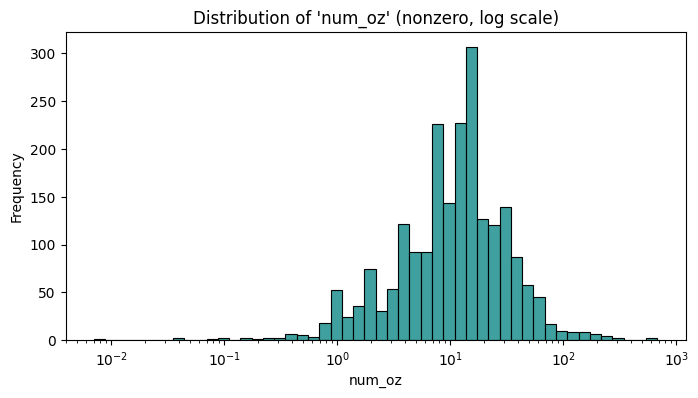

count    5000.000000
mean        7.990853
std        22.452711
min         0.000000
1%          0.000000
5%          0.000000
50%         0.000000
95%        34.000000
99%        80.000000
max       684.000000
Name: num_oz, dtype: float64


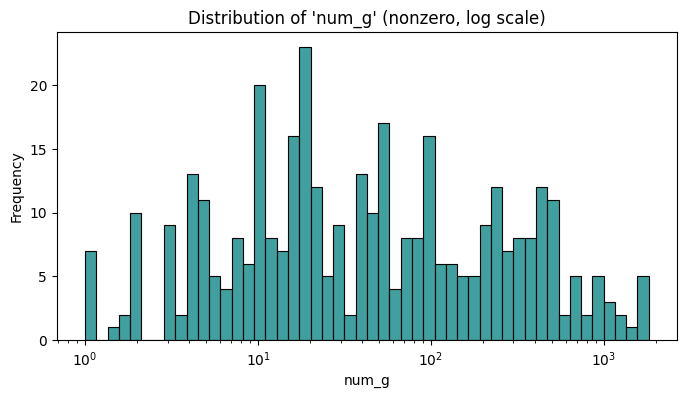

count    5000.000000
mean       11.985842
std        90.446190
min         0.000000
1%          0.000000
5%          0.000000
50%         0.000000
95%        16.000000
99%       400.000000
max      1816.000000
Name: num_g, dtype: float64


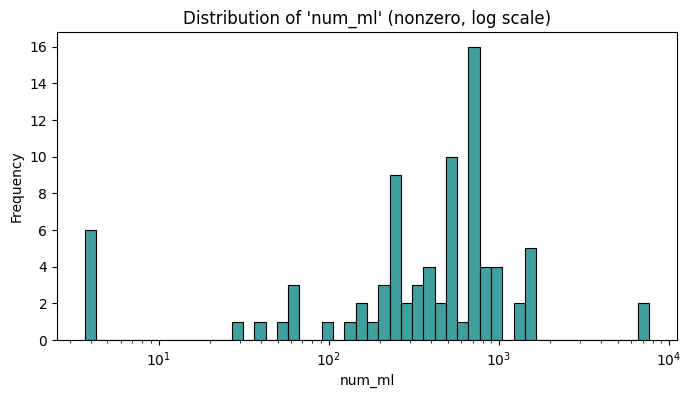

count    5000.000000
mean       11.570040
std       173.238667
min         0.000000
1%          0.000000
5%          0.000000
50%         0.000000
95%         0.000000
99%       355.200000
max      7598.000000
Name: num_ml, dtype: float64


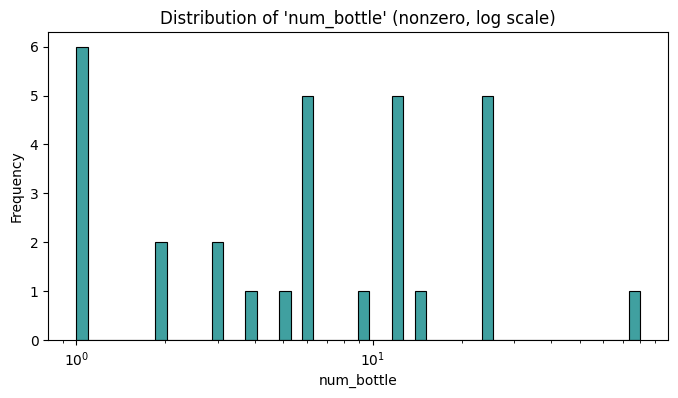

count    5000.000000
mean        0.067600
std         1.449776
min         0.000000
1%          0.000000
5%          0.000000
50%         0.000000
95%         0.000000
99%         0.000000
max        80.000000
Name: num_bottle, dtype: float64


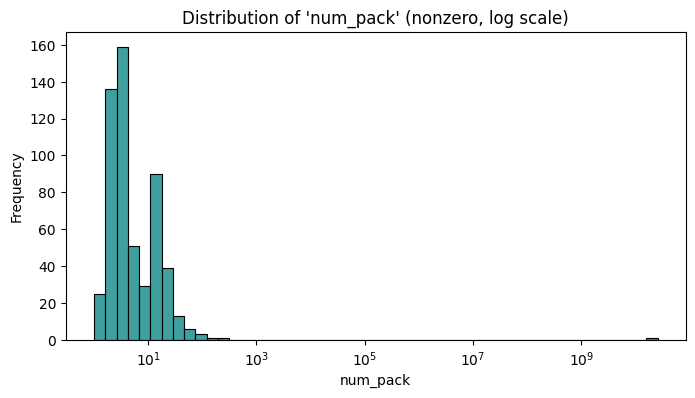

count    5.000000e+03
mean     5.135026e+06
std      3.631011e+08
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
50%      0.000000e+00
95%      4.000000e+00
99%      2.400000e+01
max      2.567512e+10
Name: num_pack, dtype: float64


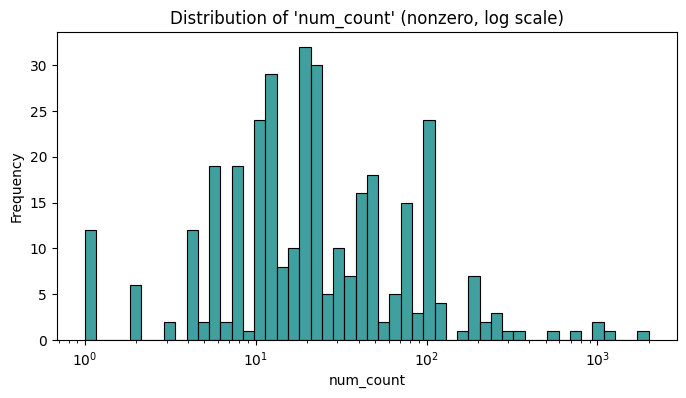

count    5000.00000
mean        3.86040
std        43.75695
min         0.00000
1%          0.00000
5%          0.00000
50%         0.00000
95%        10.00000
99%        88.02000
max      2000.00000
Name: num_count, dtype: float64


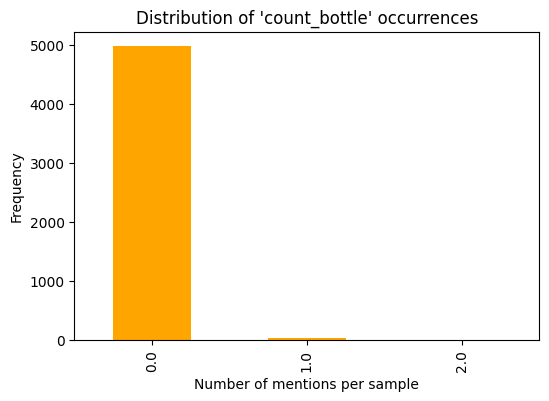

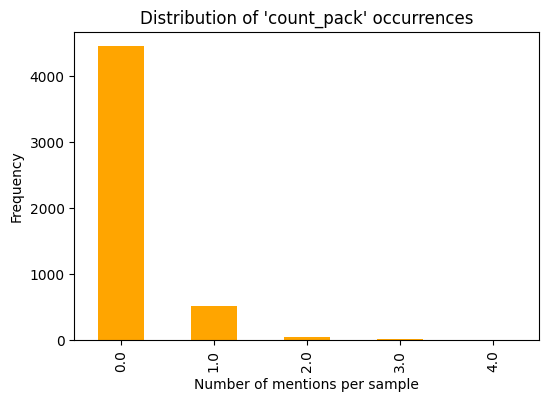

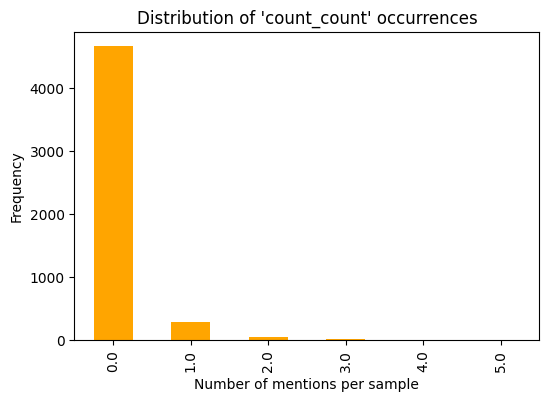

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


key_unit_features = [
    'num_oz', 'num_g', 'num_ml', 'num_bottle', 'num_pack', 'num_count'
]


for col in key_unit_features:
    if col in train_unit_feats_df.columns:
        plt.figure(figsize=(8,4))
        data = train_unit_feats_df[col]
        sns.histplot(data[data > 0], bins=50, color='teal', log_scale=True)
        plt.title(f"Distribution of '{col}' (nonzero, log scale)")
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        print(data.describe(percentiles=[.01, .05, .5, .95, .99]))


for col in ['count_bottle', 'count_pack', 'count_count']:
    if col in train_unit_feats_df.columns:
        plt.figure(figsize=(6,4))
        vc = train_unit_feats_df[col].value_counts().sort_index()
        vc.plot(kind='bar', color='orange')
        plt.title(f"Distribution of '{col}' occurrences")
        plt.xlabel('Number of mentions per sample')
        plt.ylabel('Frequency')
        plt.show()